In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
CaseName_Base = 'IEEE118'
CaseName_ByStages = CaseName_Base + '_ByStages_nc'


Folder_A = 'A.The_full_year_MILP'
Folder_D = 'D.Representative_days_based_on_RES_and_Demand'
# Folder_E = 'E.Representative_days_based_on_Line_Benefits_OptModel'
# Folder_F = 'F.Representative_days_based_on_Line_Benefit_NN_OC_fy_1'
# Folder_G = 'G.Representative_days_based_on_Line_Benefit_NN_OC_fy_2'
# Folder_H = 'H.Representative_days_based_on_Line_Benefit_NN_OC_fy_3'
# Folder_I = 'I.Representative_days_based_on_Line_Benefit_NN_OC_fy_4'

DirName  = os.getcwd()
_path_0 = os.path.join(DirName, CaseName_Base)
# category_dict = {Folder_A: "FYMILP",Folder_D: "R&D",Folder_E: "OPT_LB",Folder_F: "NN_OPCOST",Folder_G: "NN_LB",}
category_dict = {Folder_A: "FYMILP",Folder_D: "R&D"}
# colors_dict = { "FYMILP": "Blue","R&D": "Red","OPT_LB": "Black","NN_OPCOST": "Orange" ,Folder_G: "Green"}
colors_dict = { "FYMILP": "Blue","R&D": "Red"}

In [7]:
def LoadingData(dir, folder,result, case, ncluster, cm):
    if folder == 'A.The_full_year_MILP': 
        df = pd.read_csv(os.path.join(dir, folder, case, '3.Out', f'{result}.txt'), header=None, delimiter = "\t")
    else: 
        df = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '3.Out', f'{result}.txt'), header=None, delimiter = "\t")

    df = df[(df.T != 0).any()]
    df.rename(columns={0: "Seconds"}, inplace=True)
    df['CaseName'] = folder + ' - ' + case + str(ncluster)
    df['Clustering method'] = cm
#     df['Category2'] = cat2
#     df['Category3'] = cat3
    df['Number of clusters'] = ncluster
    df = df.reset_index()
#df = df.reset_index().set_index(['CaseName', 'Category1', 'Category2', 'Category3', 'Category4'])
    # df = df.set_index('CaseName', append=True)
    return df

In [8]:
# result = "CostSummary"
nbs_clusters = [(i+1)*10 for i in range(10)] + [150, 200, 250]
#nbs_clusters = [(i+1)*10 for i in range(2)]
folders = [Folder_A,Folder_D]#,Folder_E,Folder_F,Folder_G]
#folders = [Folder_A,Folder_D]
# results = ["CostSummary", "NetworkInvestment"]
results = ["ComputationTime"]

results_dfs = dict()
for result in results :
    results_dfs[result] = dict()
    for folder in folders: 
        results_dfs[result][folder] = dict()
        for nb_clusters in nbs_clusters:
            results_dfs[result][folder][nb_clusters] = LoadingData(DirName, folder,result, CaseName_Base, nb_clusters, category_dict[folder])


In [9]:
#Concatenate results dataframes 
results_dfs_concat = dict()
for result in results:
    results_dfs_concat[result]=   pd.concat([results_dfs[result][folder][nb_clusters] for nb_clusters in nbs_clusters for folder in folders])

In [14]:
#Pivot the system cost dataframe and rename some columns
results_dfs_pivot = results_dfs_concat["ComputationTime"].pivot_table(values = "Seconds",index = ["Clustering method", "Number of clusters"]).reset_index().set_index(["Clustering method", "Number of clusters"])
results_dfs_pivot.rename({"Seconds" : "STime"},axis = 1,inplace=True)

In [15]:
#Calculate difference with respect to FYMILP
diff_cols = ["STime"]
#results_dfs_pivot.loc["NN_LL","Diff TSC"] = results_dfs_pivot.loc["FYMILP",diff_col] - results_dfs_pivot.loc["NN_LL",diff_col]
for diff_col in diff_cols:
    results_dfs_pivot[f'Diff_{diff_col}'] = results_dfs_pivot[diff_col] - results_dfs_pivot.loc['FYMILP', diff_col]

In [19]:
# Add investment difference as column to existing pivot dataframe 
inv_diffs = pd.DataFrame()
#inv_diffs["Clustering method"] = results_dfs_concat["NetworkInvestment"]["Clustering method"]
inv_diffs["pu"] = results_dfs_concat["ComputationTime"].reset_index().set_index(["Clustering method", "Number of clusters"])["Seconds"] -results_dfs_concat["ComputationTime"].reset_index().set_index(["Clustering method","Number of clusters"]).loc["FYMILP"]["Seconds"]
inv_diffs["pu_abs"] = inv_diffs["pu"].abs()
results_dfs_pivot["Time difference"] = inv_diffs.groupby(["Clustering method", "Number of clusters"]).sum()["pu"]
results_dfs_pivot["Time difference abs"] = inv_diffs.groupby(["Clustering method", "Number of clusters"]).sum()["pu_abs"]

In [20]:
results_dfs_pivot

STime  Diff_STime  Time difference  \
Clustering method Number of clusters                                       
FYMILP            10                  21304           0                0   
                  20                  21304           0                0   
                  30                  21304           0                0   
                  40                  21304           0                0   
                  50                  21304           0                0   
                  60                  21304           0                0   
                  70                  21304           0                0   
                  80                  21304           0                0   
                  90                  21304           0                0   
                  100                 21304           0                0   
                  150                 21304           0                0   
                  200                 21304           0                0   
                  250                 21304           0                0   
R&D               10                    438      -20866           -20866   
                  20                    443      -20861           -20861   
                  30                    300      -21004           -21004   
                  40                    767      -20537           -20537   
                  50                   1607      -19697           -19697   
                  60                   2546      -18758           -18758   
                  70                   3946      -17358           -17358   
                  80                   3881      -17423           -17423   
                  90                   7877      -13427           -13427   
                  100                  8723      -12581           -12581   
                  150                 15987       -5317            -5317   
                  200                 51693       30389            30389   
                  250                 73896       52592            52592   

                                      Time difference abs  
Clustering method Number of clusters                       
FYMILP            10                                    0  
                  20                                    0  
                  30                                    0  
                  40                                    0  
                  50                                    0  
                  60                                    0  
                  70                                    0  
                  80                                    0  
                  90                                    0  
                  100                                   0  
                  150                                   0  
                  200                                   0  
                  250                                   0  
R&D               10                                20866  
                  20                                20861  
                  30                                21004  
                  40                                20537  
                  50                                19697  
                  60                                18758  
                  70                                17358  
                  80                                17423  
                  90                                13427  
                  100                               12581  
                  150                                5317  
                  200                               30389  
                  250                               52592

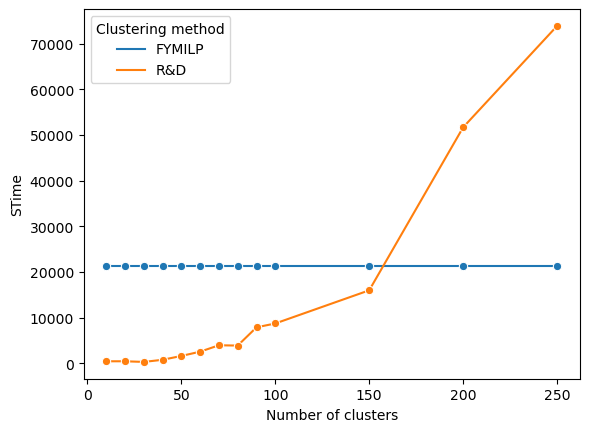

In [24]:
#Regular line plots
y = "STime"
# y= 'Time difference abs'
#y = 'Difference_from_FYMILP'
x = "Number of clusters"
sns.lineplot(data = results_dfs_pivot,x = x, y = y,hue = "Clustering method",marker = "o")
plt.savefig(f"Z.Figures/lineplot_{y}_{x}_{CaseName_Base}_highnb")